# Solving email scheduling problem

Alex Osipenko for PAIR Finance
* email: subpath@ya.ru
* LinkedIn: https://www.linkedin.com/in/aosipenko/
* Medium: https://medium.com/@subpath
* GitHub: https://github.com/subpath

The notebook is made in a follow-along way, you can scroll through and read my comments and thoughts about the dataset and modeling process. For disclaimer, it's a technical assignment and I was able to put pretty limited time and effort into it.

### TL;DR:
I used two approaches - multiclass classification and multiple regression, both methods showed to be usefull for redusing time delay between sending and openning on 50  for classification and 119 minutes in case with regression.

### What can be improved:
There are many things to be improved in this research. 

I would start by gathering more understanding of product and user's features. Then there should be better validation process than I used here (simple train/test split), for instance, if my model predicted that best time for the user n-i was 7:00 and there was no record of sending that user message at that time I was simply skipping that user and didn't include him into validation process. And with the regression model I simply used only information about the first message, that was done to keep the complexity level to the minimum. But at the same time, I might be losing valuable information. 

A number of messages that were sent are another important feature that can be considered during modeling. Not directly as a feature of course, but I could use it to add time-series components for the model. For example, based on Figure 4 and Figure 5, the first message is an important one, because many users open it with the smallest time delay comparing to other messages. So I would consider adding time delay from the previous messages and other time-series statistics to the model in cases when we are planning to send 2nd+ messages.

The metrics are also important, I used out-of-the-box metrics and then manually convert them to the product metrics like time difference. I might consider writing custom loss functions with embedded product metrics and train models on that.

In [1]:
%pylab inline 
# buil-in
import warnings

# external
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

sns.set_style('whitegrid')
# I would not use this in the ML pipeline
# it's purely to make this notebook cleaner
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
data = pd.read_csv("data.csv")

In [3]:
# first look at the data
data.head()

,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,...,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,...,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,NaN,NaN
1,-0.14,-3.21,0,1,17:00,17:11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.23,0.08,3,1,19:00,09:22,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
X1      100000 non-null float64
X2      100000 non-null float64
X3      100000 non-null int64
M       100000 non-null int64
TS00    100000 non-null object
TO00    100000 non-null object
TS01    93229 non-null object
TO01    93229 non-null object
TS02    86468 non-null object
TO02    86468 non-null object
TS03    79886 non-null object
TO03    79886 non-null object
TS04    73273 non-null object
TO04    73273 non-null object
TS05    66771 non-null object
TO05    66771 non-null object
TS06    60143 non-null object
TO06    60143 non-null object
TS07    53380 non-null object
TO07    53380 non-null object
TS08    46719 non-null object
TO08    46719 non-null object
TS09    40024 non-null object
TO09    40024 non-null object
TS10    33245 non-null object
TO10    33245 non-null object
TS11    26508 non-null object
TO11    26508 non-null object
TS12    19752 non-null object
TO12    19752 

# Exploratory data analysis

Text(0, 0.5, 'count')

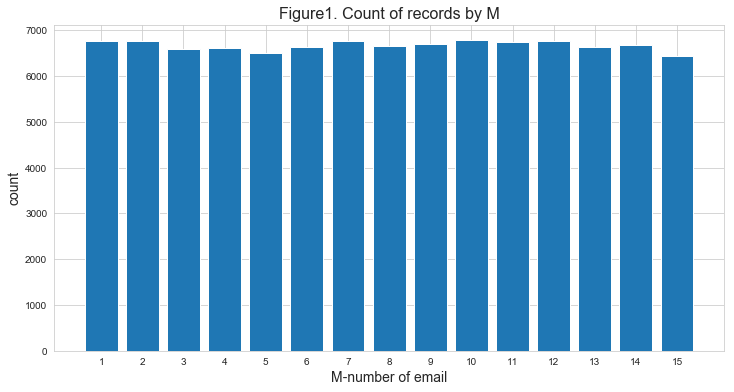

In [5]:
# look at the balance in M - number of email
pylab.figure(figsize=(12,6))
pylab.title("Figure1. Count of records by M", size=16)
pylab.xticks(data['M'].value_counts().index)
pylab.bar(data['M'].value_counts().index, data['M'].value_counts())
pylab.xlabel("M-number of email", size=14)
pylab.ylabel("count", size=14)

In [6]:
# time for sending emails is discrete
schedule = data["TS00"].sort_values().unique().tolist()
schedule

['07:00',
 '08:00',
 '09:00',
 '10:00',
 '11:00',
 '12:00',
 '13:00',
 '14:00',
 '15:00',
 '16:00',
 '17:00',
 '18:00',
 '19:00',
 '20:00']

In [7]:
# I found that there are some records with strange format like "00:-53"
# I assumed this is recording error, so I will delele "-" sign

for column in tqdm(data.loc[:, data.dtypes == 'object'].columns, desc='Cleaning invalid values'): # take only object columns
    data[column] = data[column].astype('str') 
    data[column] = data[column].apply(lambda x: x.replace('-', ''))

Cleaning invalid values: 100%|██████████| 30/30 [00:01<00:00, 28.20it/s]


In [8]:
# get lists of sending and open time column names
sending_times = [column for column in data.columns if 'TS' in column]
open_times = [column for column in data.columns if 'TO' in column]

In [9]:
# calculate differences between send time and open time and other feature preparation
for send_time_column, open_time_column in tqdm(zip(sending_times, open_times), desc='Extracting features'):
    # convert strings to datetimes
    data[send_time_column + "_datetime"] = pd.to_datetime(data[send_time_column], errors = 'coerce')
    data[open_time_column + "_datetime"] = pd.to_datetime(data[open_time_column], errors = 'coerce')
    # I will call this column as TD - time difference
    TD_column_name = send_time_column.replace("TS", "TD")
    # save as timedelta object
    data[TD_column_name + "_timedelta"] = data[open_time_column + "_datetime"] - data[send_time_column + "_datetime"]
    # save as minutes - int value
    data[TD_column_name + "_minutes"] = data[TD_column_name + "_timedelta"].apply(lambda x: x.seconds/60)
    # because it's not handy to work with time object directly
    # I will use number of minutes since beginning of the day from 00:00
    # for example time 14:00 will be converted to 840 minutes
    data[send_time_column+"_minutes_in_day"] = data[send_time_column + "_datetime"].apply(lambda x: (x-pd.to_datetime(x.date())).seconds/60)
    data[open_time_column+"_minutes_in_day"] = data[open_time_column + "_datetime"].apply(lambda x: (x-pd.to_datetime(x.date())).seconds/60)

Extracting features: 15it [08:16, 28.29s/it]


In [10]:
TD_columns = [col for col in data.columns if "_minutes" in col and 'TD' in col]
# calculate aggrigated statistics for Time difference in minutes
data['TD_mean'] = data[TD_columns].mean(axis=1)

Text(0, 0.5, 'Density')

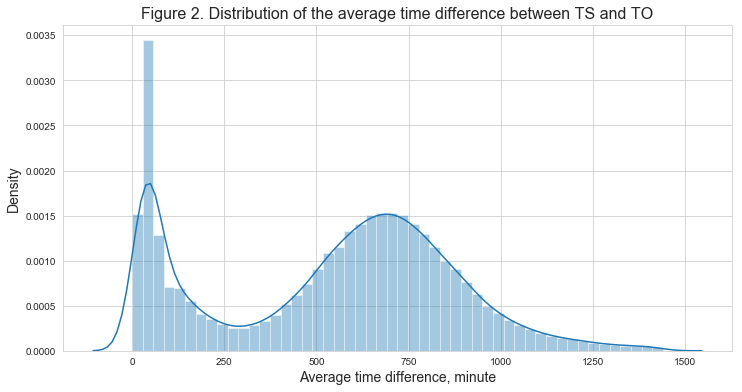

In [11]:
pylab.figure(figsize=(12,6))
pylab.title("Figure 2. Distribution of the average time difference between TS and TO", size=16)
sns.distplot(data['TD_mean'])
pylab.xlabel("Average time difference, minute", size=14)
pylab.ylabel("Density", size=14)

Looks like there are two clusters - people who opened shortly after message received and people who answering on average 10 hours later

Text(88.0, 0.5, 'the time of sending')

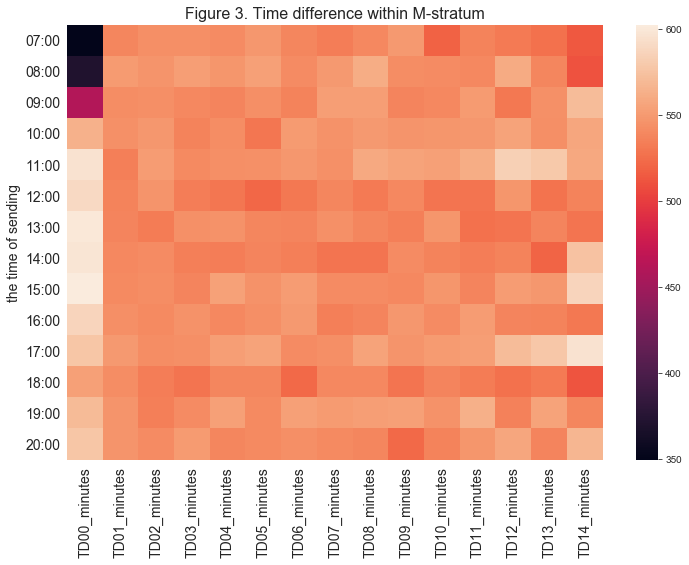

In [12]:
pylab.figure(figsize=(12, 8))
pylab.title("Figure 3. Time difference within M-stratum", size=16)
sns.heatmap(data.groupby("TS00").mean()[TD_columns])
pylab.yticks(rotation='horizontal', size=14)
pylab.xticks(size=14)
pylab.ylabel("the time of sending", size=14)

On the first message we can clearly see that openings are coming with much smaller delay if the first message was sent during morning hours: 7-9 am. Interestingly enough to see that one of the highest delays has the same first messages if they were sent afternoon.

Text(0, 0.5, 'When the first message was send \n(minutes since the beginning of the day)')

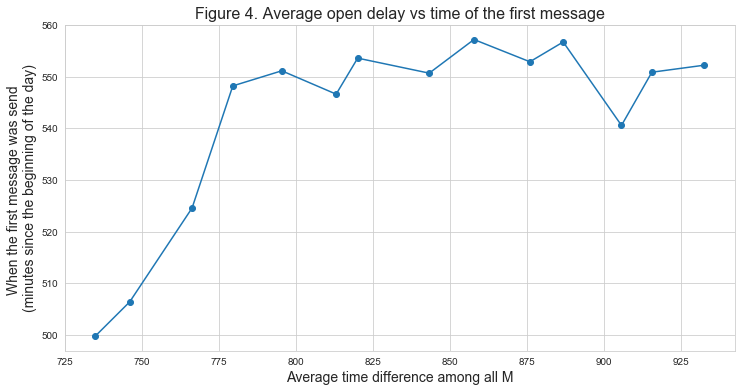

In [13]:
pylab.figure(figsize=(12, 6))
pylab.title("Figure 4. Average open delay vs time of the first message", size=16)
pylab.scatter(data.groupby("TS00").mean()['TO00_minutes_in_day'], data.groupby("TS00").mean()['TD_mean'] )
pylab.plot(data.groupby("TS00").mean()['TO00_minutes_in_day'], data.groupby("TS00").mean()['TD_mean'] )
pylab.xlabel("Average time difference among all M", size=14)
pylab.ylabel("When the first message was send \n(minutes since the beginning of the day)", size=14)

On the scatter plot above we can see that on the average time delay between the message sent and opened is smaller in the morning hours, the same pattern as on the heatmap above.

Text(0, 0.5, 'Average delay, minutes')

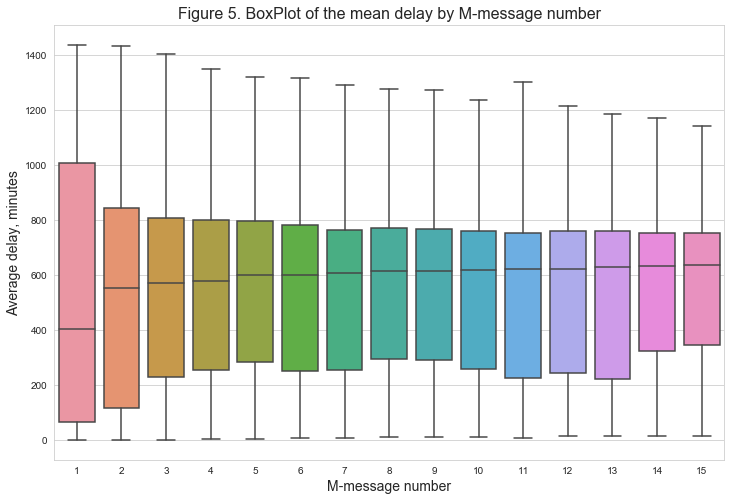

In [14]:
pylab.figure(figsize=(12,8))
pylab.title("Figure 5. BoxPlot of the mean delay by M-message number", size=16)
sns.boxplot(data=data, x='M', y='TD_mean')
pylab.xlabel("M-message number", size=14)
pylab.ylabel("Average delay, minutes", size=14)

So the average time difference in the first message has the lowest value but at the same time, it has highest variance. Interestingly enough average time difference converges with increasing M-value. 

# Labeling

In [16]:
data['smallest_TDn'] = data[TD_columns].idxmin(axis=1).apply(lambda x: x.replace("TD", "TS").replace("_minutes", ""))
data['id'] = data.index

In [17]:
def get_best_send_time(user_id: int, TS_column: str):
    """Get value of the TS."""
    return data[TS_column][data['id']==user_id].values[0]

In [18]:
data['best_time'] = data.apply(lambda x: get_best_send_time(x['id'], x['smallest_TDn']), axis=1)

In [19]:
data['best_time'].value_counts()

08:00    10295
09:00     9441
07:00     8723
10:00     7355
19:00     7317
20:00     7290
18:00     6835
17:00     6350
11:00     6298
13:00     6160
12:00     6141
14:00     6052
16:00     6022
15:00     5721
Name: best_time, dtype: int64

In [20]:
# create labels with one-hot encoders
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['best_time'].values.reshape(-1,1))
# let's see overall label balance
data['label'].value_counts()

1     10295
2      9441
0      8723
3      7355
12     7317
13     7290
11     6835
10     6350
4      6298
6      6160
5      6141
7      6052
9      6022
8      5721
Name: label, dtype: int64

In [21]:
# caching intermediate results
data.to_csv("data_intermediate_cache.csv", index=False)

# Modeling
## Feature preparation
There are 3 features **$x1, x2, x3$** - two of them **$x1, x2$** are numerical and **$x3$** is categorical
I will encode **$x3$** with BinaryEncoder and will scale all features with StandardScaler

In [22]:
# create data transformation pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# custom encoder 
class CatFeaturesEncoder(TransformerMixin, BaseEstimator):
    """Custom sklearn-based transformer for categorical values encoding."""
    def __init__(self, cat_column: str):
        self._cat_column = cat_column
        self._transformer = LabelBinarizer()
        
    def fit(self, x:pd.DataFrame, y=None):
        """Mandatory method for sklearn transformer."""
        return self
    
    def transform(self, x:pd.DataFrame, y=None):
        """Mandatory method for sklearn, will transformed categorical features."""
        x = x.copy()
        transformed_features = pd.DataFrame(self._transformer.fit_transform(x[self._cat_column]))
        return pd.concat([x[['X1', 'X2']].reset_index(drop=True), transformed_features], axis=1)

In [23]:
# feature transformation pipeline
feature_preparation = Pipeline([
                ('encoder', CatFeaturesEncoder(cat_column="X3")),
                ('scaling', StandardScaler())
            ])

In [24]:
# run example
pd.DataFrame(feature_preparation.fit_transform(data[['X1', 'X2', 'X3']].iloc[:5])).head()

,0,1,2,3,4
0,-0.872449,0.111627,-0.5,1.224745,-0.816497
1,0.277692,-1.773091,2.0,-0.816497,-0.816497
2,1.697235,0.888163,-0.5,-0.816497,1.224745
3,0.029013,-0.228108,-0.5,-0.816497,1.224745
4,-1.131490,1.001408,-0.5,1.224745,-0.816497


In [25]:
train, test, y_train, y_test = train_test_split(data,
                                                data['label'].values, 
                                                test_size=0.1, 
                                                random_state=42)
# data preprocessing after split
X_train = feature_preparation.fit_transform(train[['X1', 'X2', 'X3']])

# I append test dataset to the train to fit feature preparation pipeline
# It's kinda how it might looks like in the production
feature_preparation.fit(data[['X1', 'X2', 'X3']])
X_test = feature_preparation.fit_transform(test)

## Multiclass classification approach
because email sending time is discrete, we can take a multiclass classification approach, by choosing for each user the best time for sending an email by classifying him into one of the 14 classes.

Text(0.5, 1.0, 'Figure 6. Heatmap of the confusion matrix with OneVsRestClassifier')

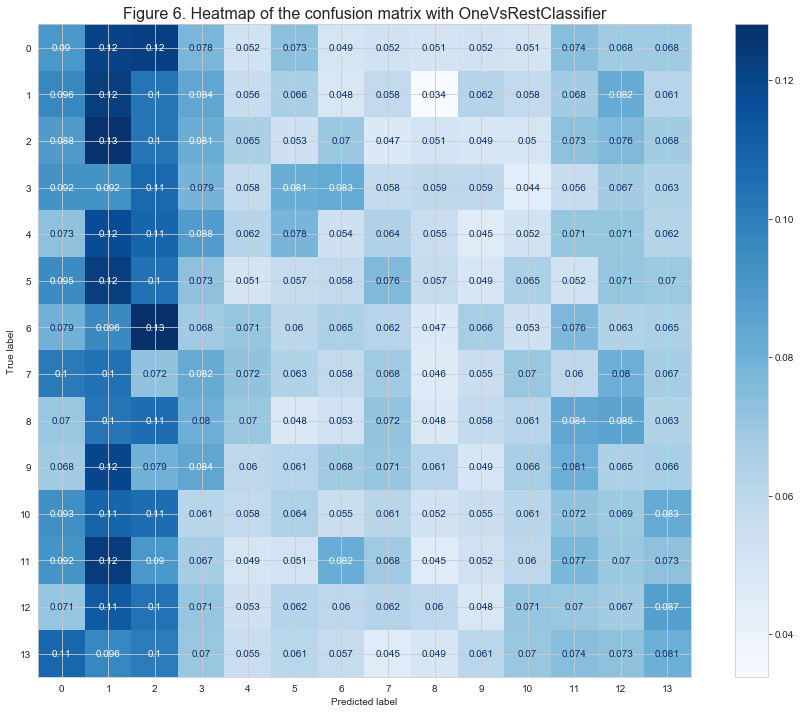

In [26]:
model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(16, 12))

disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=pylab.cm.Blues,
                                 normalize='true', ax=ax)
disp.ax_.set_title("Figure 6. Heatmap of the confusion matrix with OneVsRestClassifier", size=16)

Text(0.5, 1.0, 'Figure 7. Heatmap of the confusion matrix with OneVsOneClassifier')

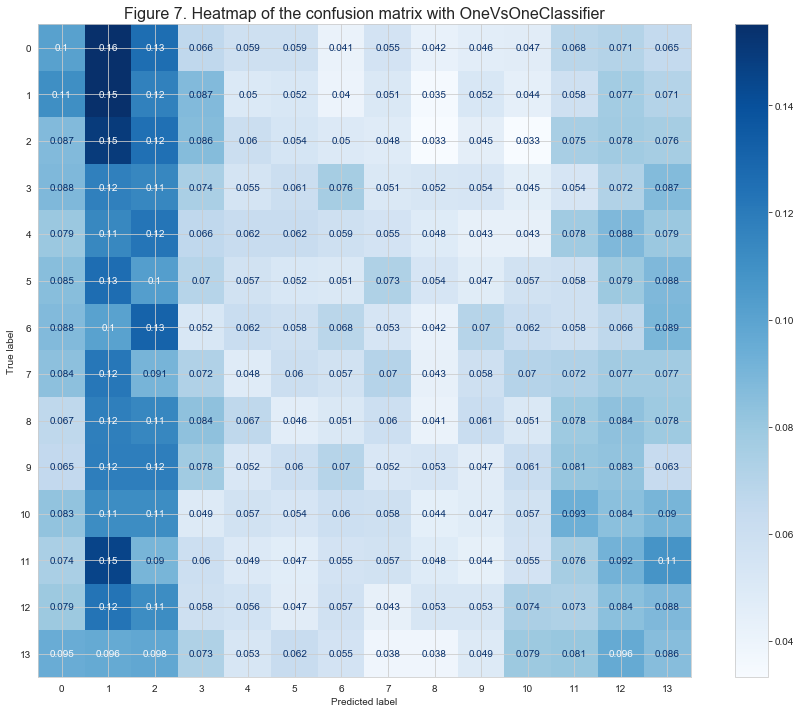

In [27]:
model = OneVsOneClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(16, 12))
disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=pylab.cm.Blues,
                                 normalize='true', ax=ax)
disp.ax_.set_title("Figure 7. Heatmap of the confusion matrix with OneVsOneClassifier", size=16)

OneVSOne and OneVSRest have fairly similar performance. Most of the error produced by prediction of the class "1", which is probably causing by a class imbalance - for example class "1" has almost twice more records than other classes. 

The confusion matrix is a pretty handy way to visualize model performance especially in the multiclass classification problem, but product-wise is not very useful. It's not showing actual time-difference we can expect between sending email and email opening. At the same time, TruePositive numbers from the confusion matrix seem pretty low for example by predicting label "1" for the user we are correct at our best only 17% of the time.

## Results interpretation and comparison with the baseline

As a baseline model I will use time difference from actual first message TD00_minutes

In [28]:
predictions = model.predict(X_test)

test['model_prediction_label'] = predictions
test['model_prediction_time'] = label_encoder.inverse_transform(predictions)

In [36]:
def get_time_diff_by_prediction(TS_value:str, id_:int):
    """Get time difference in minutes."""
    TD = None
    for TS in sending_times:
        df = test[(test['id']==id_) & (test[TS]==TS_value)]
        if not df.empty:
            TD = TS.replace("S", "D") + "_minutes"
            break
    if TD is not None:
        return test[(test['id']==id_)][TD].values[0]
    else:
        return np.nan


In [37]:
# In case when model predict best time as 7:00 and for this user I have actual result for sending time at 18:00, 
# I will not change model predictions and will skip comparison for this record

test['classifier_model_TD'] = test.apply(lambda x: get_time_diff_by_prediction( x['model_prediction_time'], x['id']), axis=1)

In [38]:
# caching intermediate results
test.to_csv("test_intermediate_cache.csv", index=False)

In [40]:
results = test[['TD00_minutes', 'classifier_model_TD']].dropna()
results['comparison'] = results['classifier_model_TD'] - results['TD00_minutes']

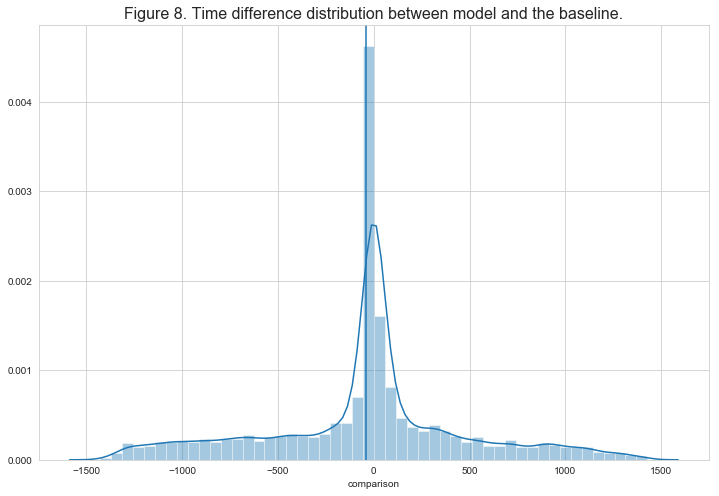

In [41]:
pylab.figure(figsize=(12,8))
pylab.title("Figure 8. Time difference distribution between model and the baseline.", size=16)
sns.distplot(results['comparison'])
pylab.axvline(results['comparison'].mean())

On average it looks like my model causes a decrease in the time delay, but distribution is highly non-Gaussian, let's use bootstrapping to investigate it further.

In [42]:
n_runs = 10_000
sample_size = 200
sample_average_distribution = []
for seed in tqdm(range(n_runs), desc='Bootstrapping'):
    np.random.seed(seed)
    sample_average_distribution.append(np.mean(np.random.choice(results['comparison'].values, sample_size)))

Bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 15218.43it/s]


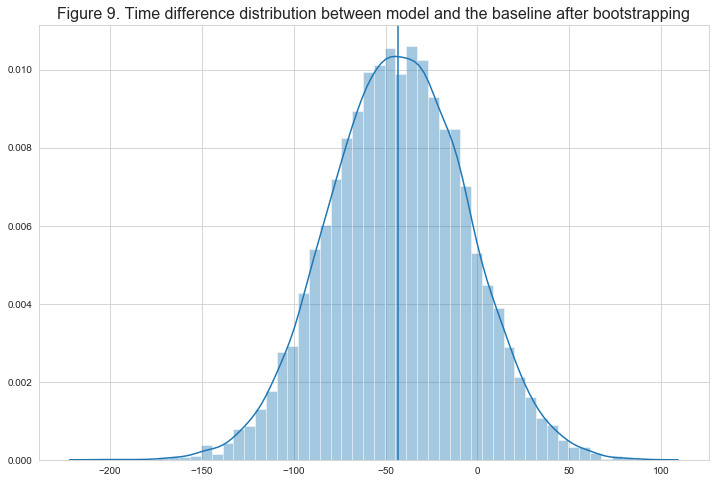

In [43]:
pylab.figure(figsize=(12,8))
pylab.title("Figure 9. Time difference distribution between model and the baseline after bootstrapping", size=16)
sns.distplot(sample_average_distribution)
pylab.axvline(np.mean(sample_average_distribution))

#### So by choosing time-based on the model, we would decrease the time delay between sending and opening on average by -50 minutes. Let's calculate t-statistics.

In [46]:
from scipy import stats

# 1 sample ttest to compare population mean with 0
stats.ttest_1samp(sample_average_distribution, 0)

# p-value is very small so it was rounded to 0

Ttest_1sampResult(statistic=-116.76368890157387, pvalue=0.0)

**We can say that model performance has statistical significance**

## Another approach - multiple regressions

So multiclass classification showed positive results with an out-of-the-box solution, there are so much to be improved. But on this technical assignment, I would like to research another approach - multiple regressions. Instead of creating states and turn into a classification problem, let's consider it a regression problem, where we are trying to estimate TD - expected time delay between sending and opening.

To speed up the whole process I will use only data from the first message TS00 and TO00, because every user had that first message and in cases when users received several messages in a different time we need to research the best way to aggregate results and take into account M-j number of the message, which is topic for another research.

My hypothesis:
we have sheduled messages at $[07:00, 08:00, 09:00, ... 20:00]$ for each time I will fit regression model, so there will be 15 models in total. Each model will be train on $X1, X2, X3$ as features and TD00 as target variable.

In [47]:
from sklearn.ensemble import RandomForestRegressor
y_train = train['TD00_minutes'].values
y_test = test['TD00_minutes'].values

In [48]:
model = {}
for time in tqdm(schedule, desc='Training regressors'):
    data_ = train[train['TS00']==time]
    y_ = data_['TD00_minutes'].values
    x_ = feature_preparation.fit_transform(data_[['X1', 'X2', 'X3']])
    model[time] = RandomForestRegressor().fit(x_, y_)

Training regressors: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


In [49]:
# run prediction example
predictions = {}
user = X_test[0]
for time in schedule:
    predictions[time] = model[time].predict([user])

In [50]:
{k: v for k, v in sorted(predictions.items(), key=lambda item: item[1])}

{'07:00': array([345.39]),
 '10:00': array([346.29]),
 '08:00': array([418.67]),
 '13:00': array([554.22]),
 '14:00': array([567.5645]),
 '09:00': array([695.7]),
 '16:00': array([769.5]),
 '20:00': array([868.78]),
 '19:00': array([869.89]),
 '17:00': array([887.54]),
 '11:00': array([971.76]),
 '18:00': array([972.23]),
 '15:00': array([991.78666667]),
 '12:00': array([1069.69])}

So for the example above we can see that depending on sending time model expects different time delay. On the example above best time to send email is 18:00.

## Calculate metrics and compare with the baseline

In [51]:
time_to_send = []
expected_delay = []

for user in tqdm(X_test, desc="Running predictions"):
    predictions_ = {}
    for time in schedule:
        predictions_[time] = model[time].predict([user])
    predictions_ = {k: v for k, v in sorted(predictions_.items(), key=lambda item: item[1])}
    time_to_send.append(list(predictions_.keys())[0])
    expected_delay.append(list(predictions_.values())[0][0])

Running predictions: 100%|██████████| 10000/10000 [19:26<00:00,  9.35it/s]


In [52]:
test['regression_best_time'] = time_to_send
test['regression_expected_delay'] = expected_delay

In [53]:
test['regression_TD'] = test.apply(lambda x: get_time_diff_by_prediction( x['regression_best_time'], x['id']), axis=1)

In [54]:
# caching intermediate results
test.to_csv("test_intermediate_cache.csv", index=False)

In [55]:
results = test[['TD00_minutes', 'regression_TD']].dropna()
results['comparison'] = results['regression_TD'] - results['TD00_minutes']

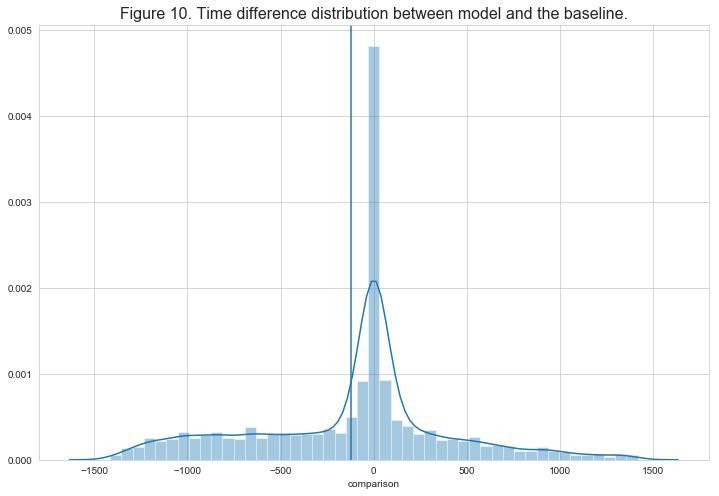

In [57]:
pylab.figure(figsize=(12,8))
pylab.title("Figure 10. Time difference distribution between model and the baseline.", size=16)
sns.distplot(results['comparison'])
pylab.axvline(np.mean(results['comparison']))

Again let's do the bootstrapping

In [58]:
n_runs = 10_000
sample_size = 200
sample_average_distribution = []
for seed in tqdm(range(n_runs), desc='Bootstrapping'):
    np.random.seed(seed)
    sample_average_distribution.append(np.mean(np.random.choice(results['comparison'].values, sample_size)))

Bootstrapping: 100%|██████████| 10000/10000 [00:00<00:00, 24818.01it/s]


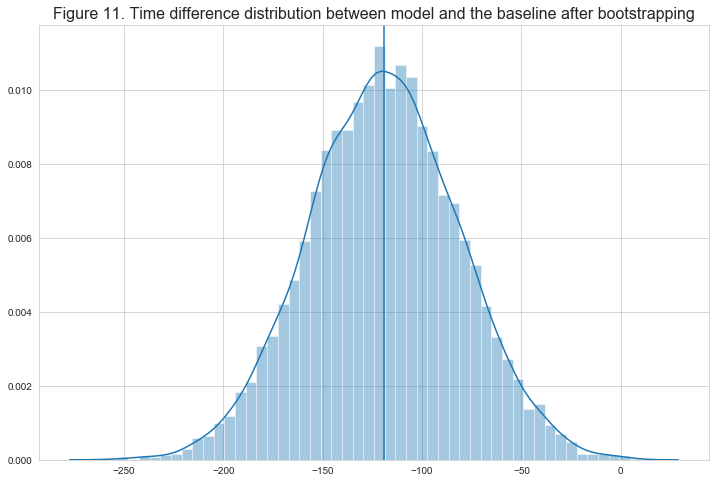

In [59]:
pylab.figure(figsize=(12,8))
pylab.title("Figure 11. Time difference distribution between model and the baseline after bootstrapping", size=16)
sns.distplot(sample_average_distribution)
pylab.axvline(np.mean(sample_average_distribution))

#### By scheduled sending time with the regression model we can on average decrease opening time delay by 119 minutes. 

In [62]:
# as a formality let's make ttest
stats.ttest_1samp(sample_average_distribution, 0)

# p-value is very small so it was rounded to 0

Ttest_1sampResult(statistic=-317.4740012487519, pvalue=0.0)

In [ ]:
# caching intermediate results
test.to_csv("test_intermediate_cache.csv", index=False)

# References:
**papers I've read to familiarize myself with the topic**

1. Tyler JR, Tang JC (2003). When can I expect an email response? A
study of rhythms in email usage. In Proceedings of the Eighth
Conference on European Conference on Computer Supported
Cooperative Work (Helsinki, Finland, September 14 - 18, 2003).
Kuutti K, Karsten EH, Fitzpatrick G, Dourish P, Schmidt K, Eds.
ECSCW. Kluwer Academic Publishers, Norwell, MA, 239-258.


2. Applying machine learning techniques for e-mail
management: solution with intelligent e-mail reply
prediction. Taiwo Ayodele and Shikun Zhou.
Department of Electronics and Computer Engineering, University of Portsmouth, United Kingdom.August, 2009